## moon data example

In [1]:
%matplotlib inline
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

Using TensorFlow backend.


In [2]:
import sys
sys.path.append('/home/admin/github/wordroid.sblo.jp/lib')
from keras_ex.gkernel import GaussianKernel, GaussianKernel2, GaussianKernel3

In [3]:
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn import cluster, datasets, mixture

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from keras.layers import Input, Embedding, LSTM, GRU, Dense, Dropout, Lambda, \
    Conv1D, Conv2D, Conv3D, \
    Conv2DTranspose, \
    AveragePooling1D, \
    MaxPooling1D, MaxPooling2D, MaxPooling3D, \
    GlobalAveragePooling1D, \
    GlobalMaxPooling1D, GlobalMaxPooling2D, \
    LocallyConnected1D, LocallyConnected2D, \
    concatenate, Flatten, Average, Activation, \
    RepeatVector, Permute, Reshape, Dot, \
    multiply, dot, add, \
    PReLU, \
    Bidirectional, TimeDistributed, \
    SpatialDropout1D, \
    BatchNormalization
from keras.models import Model, Sequential
from keras import losses
from keras.callbacks import BaseLogger, ProgbarLogger, Callback, History
from keras.wrappers.scikit_learn import KerasClassifier
from keras import regularizers
from keras import initializers
from keras.metrics import categorical_accuracy
from keras.constraints import maxnorm, non_neg
from keras.optimizers import RMSprop
from keras.utils import to_categorical
from keras import backend as K

### create sample data

In [4]:
n_samples = 1500

X, y = datasets.make_moons(n_samples=n_samples, noise=.08, random_state=0)
df = pd.DataFrame(X)
df.columns = ["col1", "col2"]
df['cls'] = y

df.head()

,col1,col2,cls
0,-0.368750,0.953681,0
1,0.894133,0.223444,0
2,2.077294,0.497075,1
3,0.931950,0.125217,0
4,2.041592,0.210389,1


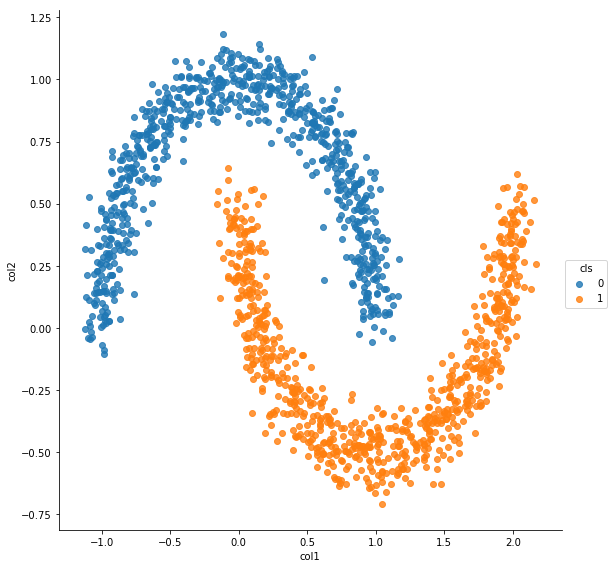

In [5]:
sns.lmplot("col1", "col2", hue="cls", data=df, fit_reg=False, size=8)

### create model

In [6]:
num_landmark = 30

def make_modelz():
    inp = Input(shape=(2,), name='inp')
    oup = inp
    
    oup = GaussianKernel3(num_landmark, 2, name='gkernel1')(oup)
    oup = Dense(1, activation='sigmoid', name='classifier')(oup)
    model = Model(inp, oup)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return {
        'model': model,
    }

models = make_modelz()
model = models['model']
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inp (InputLayer)             (None, 2)                 0         
_________________________________________________________________
gkernel1 (GaussianKernel3)   (None, 30)                61        
_________________________________________________________________
classifier (Dense)           (None, 1)                 31        
Total params: 92
Trainable params: 92
Non-trainable params: 0
_________________________________________________________________


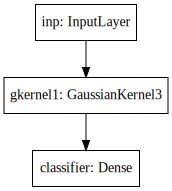

In [7]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

### show initial landmarks

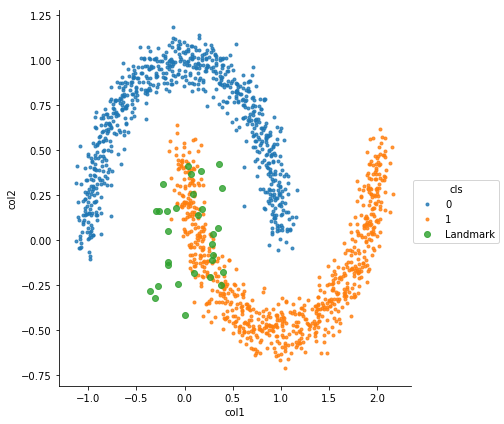

In [8]:
wgt = model.get_layer('gkernel1').get_weights()[0]
df = pd.DataFrame(np.vstack([X, wgt]))
df.columns = ["col1", "col2"]
df['cls'] = [str(ee) for ee in y] + ['Landmark']*wgt.shape[0]
sns.lmplot("col1", "col2", markers=['.', '.', 'o'], hue="cls", data=df, fit_reg=False, size=6)

### set initial gamma of GaussianKernel leyaer

In [9]:
init_wgt = model.layers[1].get_weights()
init_wgt

[array([[  7.05451071e-02,   3.66645962e-01],
        [ -3.09751660e-01,  -3.19633335e-01],
        [  3.99205357e-01,  -1.78086519e-01],
        [  3.59646946e-01,   4.22149748e-01],
        [  2.88223833e-01,  -1.96360350e-02],
        [  3.07307243e-02,   4.11821693e-01],
        [ -2.40236521e-04,  -4.18532699e-01],
        [ -1.76802874e-01,   5.13153076e-02],
        [  1.74278051e-01,   3.83331031e-01],
        [ -2.63869166e-01,   1.60776168e-01],
        [  2.97471553e-01,  -8.34004283e-02],
        [ -1.73784375e-01,  -1.22804284e-01],
        [  2.60182410e-01,  -2.07483843e-01],
        [  2.95451909e-01,   3.55445147e-02],
        [ -3.56810659e-01,  -2.83004999e-01],
        [ -1.71170086e-01,  -1.39888793e-01],
        [ -2.97200173e-01,   1.63716882e-01],
        [  9.36864316e-02,  -1.83958009e-01],
        [ -1.85156286e-01,   1.60143942e-01],
        [  9.23251808e-02,   2.57225305e-01],
        [  3.83508295e-01,   2.90308207e-01],
        [ -8.43037665e-02,   1.804

In [10]:
init_wgt[1][0] = np.log(1/(2*2*0.1))

In [11]:
model.layers[1].set_weights(init_wgt)

### train

In [12]:
model.fit(X, y, verbose=0,
          batch_size=32,
          epochs=150)

/home/admin/miniconda3/envs/da02/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


### show trained landmarks

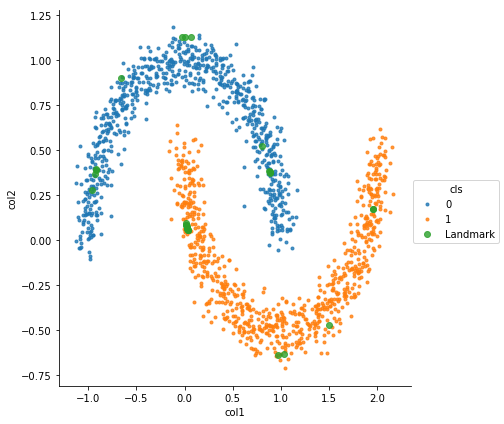

In [13]:
wgt = model.get_layer('gkernel1').get_weights()[0]
df = pd.DataFrame(np.vstack([X, wgt]))
df.columns = ["col1", "col2"]
df['cls'] = [str(ee) for ee in y] + ['Landmark']*wgt.shape[0]
sns.lmplot("col1", "col2", markers=['.', '.', 'o'], hue="cls", data=df, fit_reg=False, size=6)

### predict

In [14]:
y_pred = model.predict(X)

In [15]:
df = pd.DataFrame(X)
df.columns = ["col1", "col2"]
df['cls'] = (0.5<y_pred[:,0]).astype(int)
df.head()

,col1,col2,cls
0,-0.368750,0.953681,0
1,0.894133,0.223444,0
2,2.077294,0.497075,1
3,0.931950,0.125217,0
4,2.041592,0.210389,1


### plot predicted class

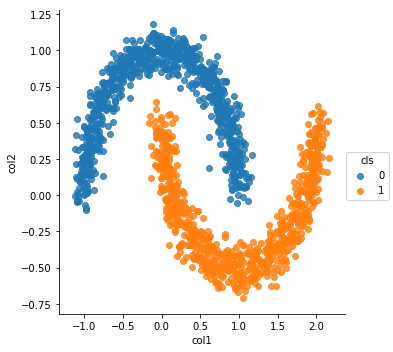

In [16]:
sns.lmplot("col1", "col2", hue="cls", data=df, fit_reg=False)

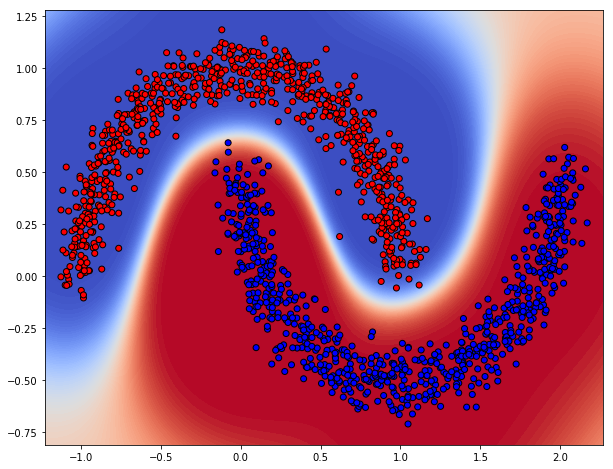

In [17]:
h = .01
x_min, x_max = X[:, 0].min() - .1, X[:, 0].max() + .1
y_min, y_max = X[:, 1].min() - .1, X[:, 1].max() + .1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
y_pred = model.predict(np.c_[xx.ravel(), yy.ravel()], batch_size=1024)

cm = plt.cm.coolwarm
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
y_pred = y_pred.reshape(xx.shape)
plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, y_pred, 100, cmap=cm, alpha=1)
plt.scatter(X[:,0], X[:,1], c=y, cmap=cm_bright, edgecolors='k')